# MNIST Dataset: Density Forests

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time
from sklearn.manifold import TSNE
from sklearn import decomposition
import warnings

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from baselines.helpers import *
from baselines.plots import *
from helpers.data_augment import *
from helpers.helpers import *
from helpers.plots import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13904020317641895483
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10959175680
locality {
  bus_id: 1
}
incarnation: 2989298069219355892
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train_all, return_counts=True))

label_to_remove = 0

# remove all trainig samples containing a label label_to_remove
x_train = x_train_all[y_train_all!=label_to_remove]
y_train = y_train_all[y_train_all!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (54077, 28, 28, 1)
54077 train samples
9020 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = True;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')
else :
    model = load_model('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions for the unseen class

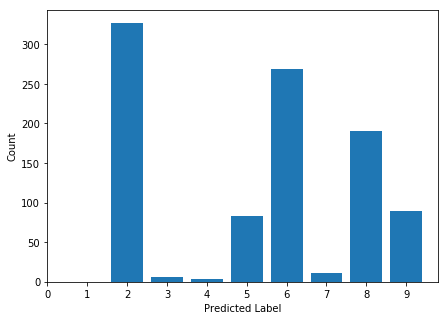

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../Figures/DF/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Avarage certitude for unseen class: 1-max_margin
c = get_acc_net_max_margin(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 50.36 %
Std accuracy: 31.16 %
7.55% of all predictions made with an accuracy higher than 0.95%


In [7]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = get_y_pred_labels(y_pred_seen, label_to_remove, background=False)

c = get_acc_net_max_margin(y_pred_seen)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.42 %
Std accuracy: 8.65 %
95.52 % of all predictions made with an accuracy higher than 0.95%


# Activation weights visualization

(1, 1, 24, 24, 64)


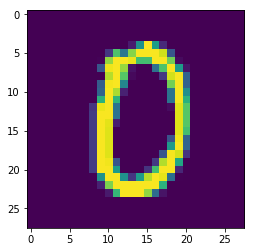

In [8]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

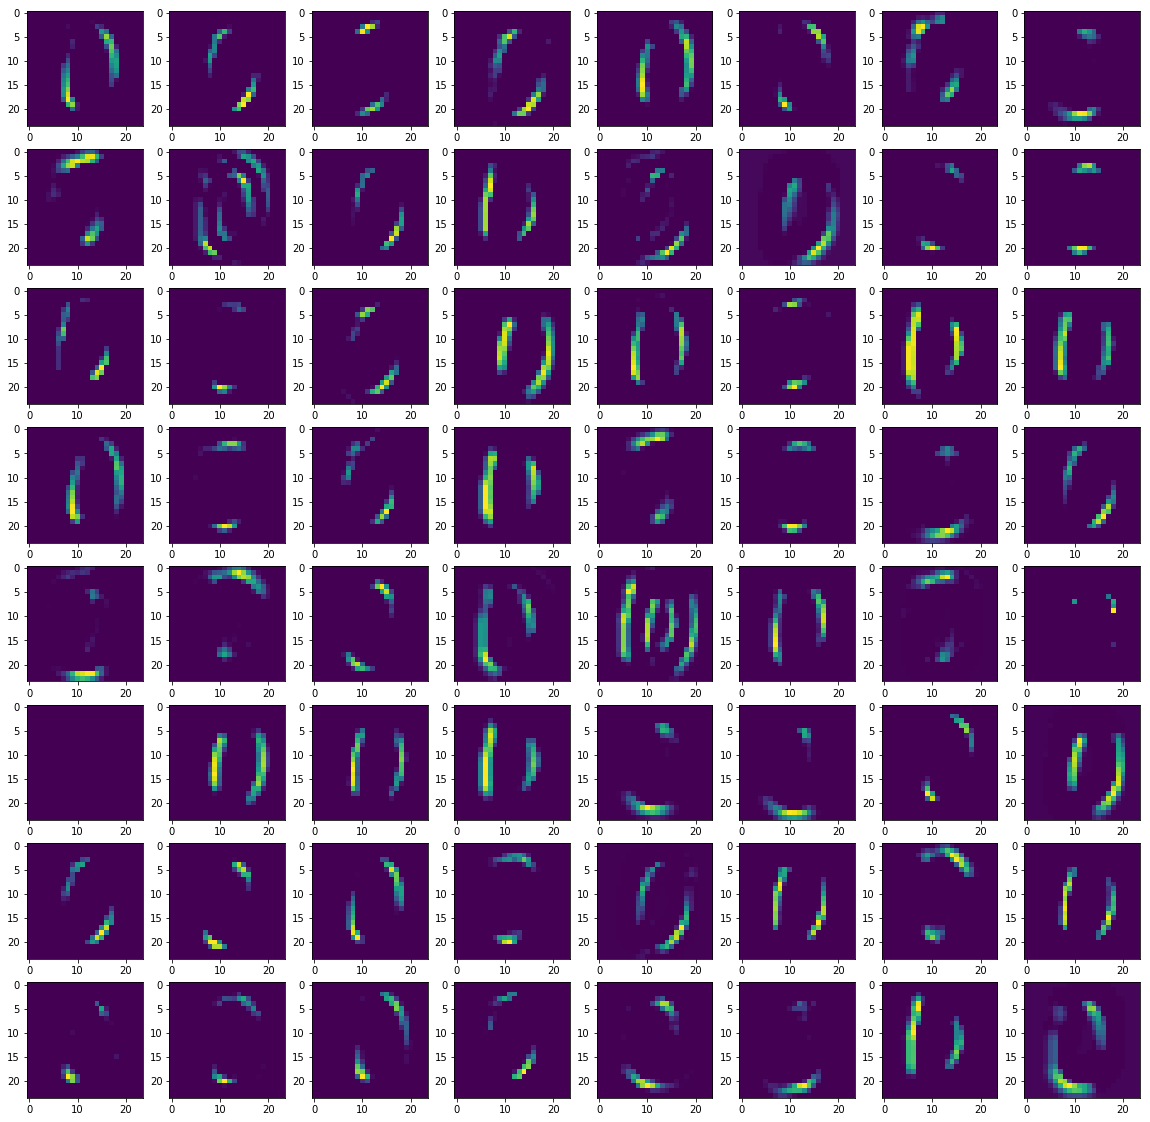

In [9]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

# Density Forest
## Get Activations, PCA, t-SNE

In [10]:
# get activation weights of last layer
act_unseen = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(act_unseen))

n_points = 10000
act_train = get_activations(model, 6, x_train[:n_points])[0]
print(np.shape(act_train))

act_test = get_activations(model, 6, x_test_all)[0]
print(np.shape(act_test))

(980, 128)
(10000, 128)
(10000, 128)


In [11]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_all, np.arange(n_classes), pts_per_class)

In [12]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.014s...
[t-SNE] Computed neighbors for 3000 samples in 1.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.837052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.593285
[t-SNE] Error after 500 iterations: 1.023232


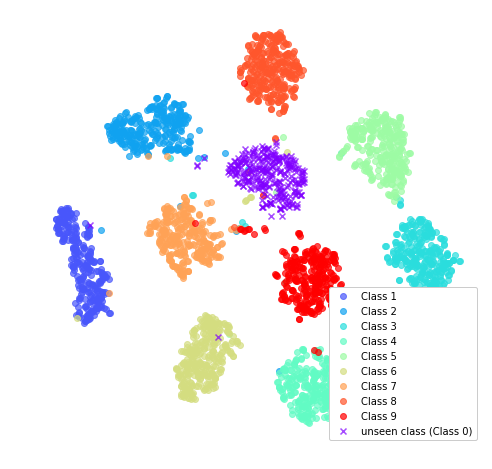

In [13]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.asarray([x for x in range(n_classes) if x != label_to_remove])

# plot
tsne_y = y_test_all[np.concatenate(dataset_subset_indices)]
fig, ax = plt.subplots(1,1, figsize=(8,8))
plot_tsne(tsne_all, tsne_y, ax, classes_to_keep, colors, names,
          class_to_remove=label_to_remove, s_name="../Figures/PCA/MNIST_t-SNE_before.pdf")

Variance explained by first 15 components: 0.88


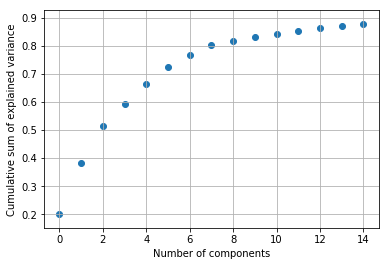

In [14]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/DF/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [15]:
X_train = pca.transform(act_train)
pca.fit(act_train)
X_test = pca.transform(act_test)

In [16]:
# t-SNE visualization after PCA
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_all = tsne.fit_transform(X_test[np.concatenate(dataset_subset_indices)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.003s...
[t-SNE] Computed neighbors for 3000 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.001307
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.674500
[t-SNE] Error after 500 iterations: 0.945475


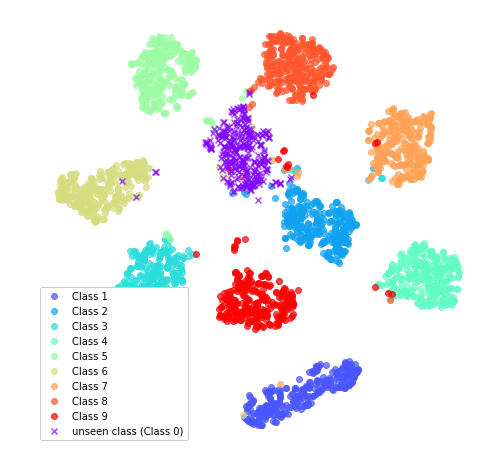

In [17]:
# plot
fig, ax = plt.subplots(1,1, figsize=(8,8))
plot_tsne(tsne_all, tsne_y,
          ax, classes_to_keep, colors, names,
          class_to_remove=label_to_remove, s_name="../Figures/PCA/MNIST_t-SNE_after.pdf")

#### Visualize first two components of PCA

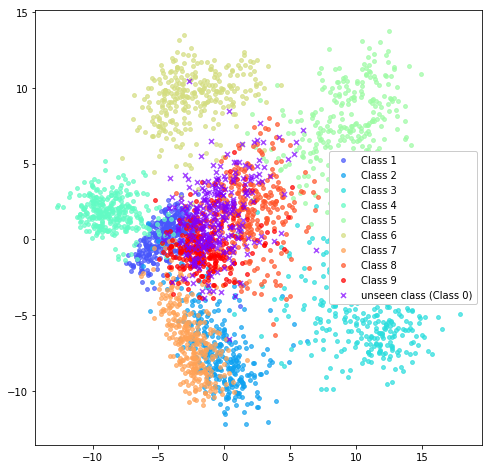

In [18]:
# test sample (with unseen class)
fix, axes = plt.subplots(1,1,figsize=(8,8))
plot_pca_2d(X_test[:,:2], y_test_all, axes, classes_to_keep, names, colors, class_to_remove=label_to_remove, subsample_pct=.3)
plt.show()

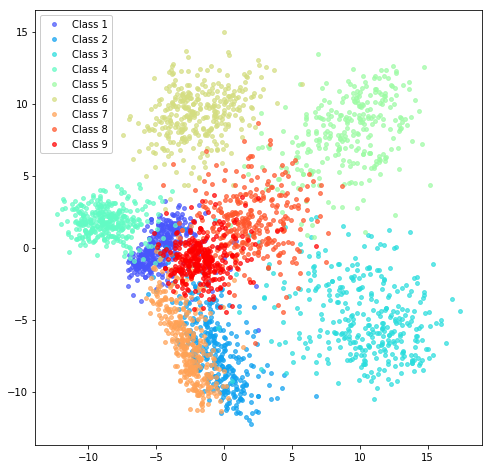

In [19]:
# training sample (without unseen class)
fix, axes = plt.subplots(1,1,figsize=(8,8))
y_true = get_y_pred_labels(y_train[:n_points],class_to_remove=label_to_remove, background=False)
plot_pca_2d(X_train[:,:2], y_true, axes, classes_to_keep, names, colors, subsample_pct=.3)
plt.show()


## Create Density Forest

### Dummy Test on t-SNE
Problem: Can not really separate into training / test set, since no equal tranformation applicable

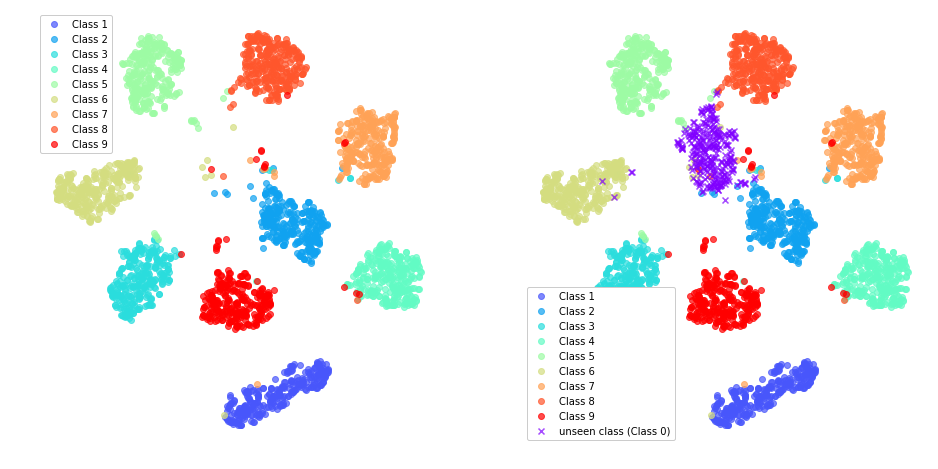

In [20]:
# indexes of all tsne points of seen classes
_from = np.arange(pts_per_class * label_to_remove)
_to = np.arange((pts_per_class * (label_to_remove+1)), len(tsne_all))
ind = np.concatenate((_from,_to))

fig, axes = plt.subplots(1, 2, figsize=(16,8))
plot_tsne(tsne_all[ind], tsne_y[ind], axes[0], classes_to_keep, 
          colors, names)

plot_tsne(tsne_all, tsne_y, axes[1], classes_to_keep, 
          colors, names, class_to_remove=label_to_remove)
plt.show()

In [21]:
# create DF
root_nodes = df_create(tsne_all[ind], max_depth=3, min_subset=.1, 
                       n_trees=50, subsample_pct=.5, n_max_dim=0,
                       n_jobs=-1, verbose=10, fact_improvement=.1, 
                       funct=create_density_tree, n_clusters=len(classes_to_keep))

Number of points on which to train each tree: 1350
Minimum number of points in each leaf: 135


[Parallel(n_jobs=40)]: Done   7 out of  50 | elapsed:    1.9s remaining:   11.5s
[Parallel(n_jobs=40)]: Done  13 out of  50 | elapsed:    2.0s remaining:    5.7s
[Parallel(n_jobs=40)]: Done  19 out of  50 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=40)]: Done  25 out of  50 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=40)]: Done  31 out of  50 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  37 out of  50 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  43 out of  50 | elapsed:    2.6s remaining:    0.4s
[Parallel(n_jobs=40)]: Done  50 out of  50 | elapsed:    2.8s finished


Number of created root nodes: 50
Mean number of clusters created per tree: 13


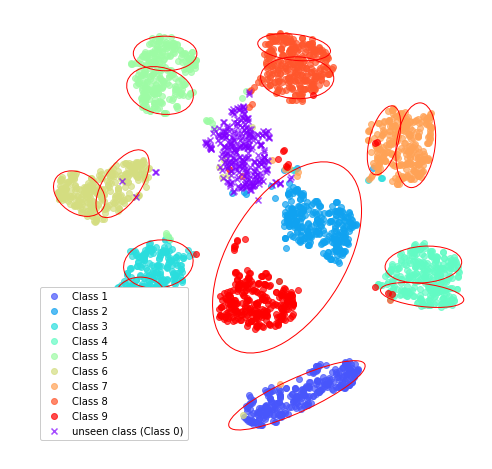

In [22]:
# show covariance ellipses of one tree
covs, means = get_clusters(root_nodes[9],[],[])
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,8)
plot_tsne(tsne_all, tsne_y, ax, classes_to_keep, 
          colors, names, class_to_remove=label_to_remove)
plot_ellipses(ax, covs=covs, means=means)

plt.show()

In [23]:
# traverse DF
probas = df_traverse(tsne_all, root_nodes, 0, standardize=False)

In [24]:
#probas -= np.min(probas)
#probas /= np.max(probas)
probas = np.log(probas)

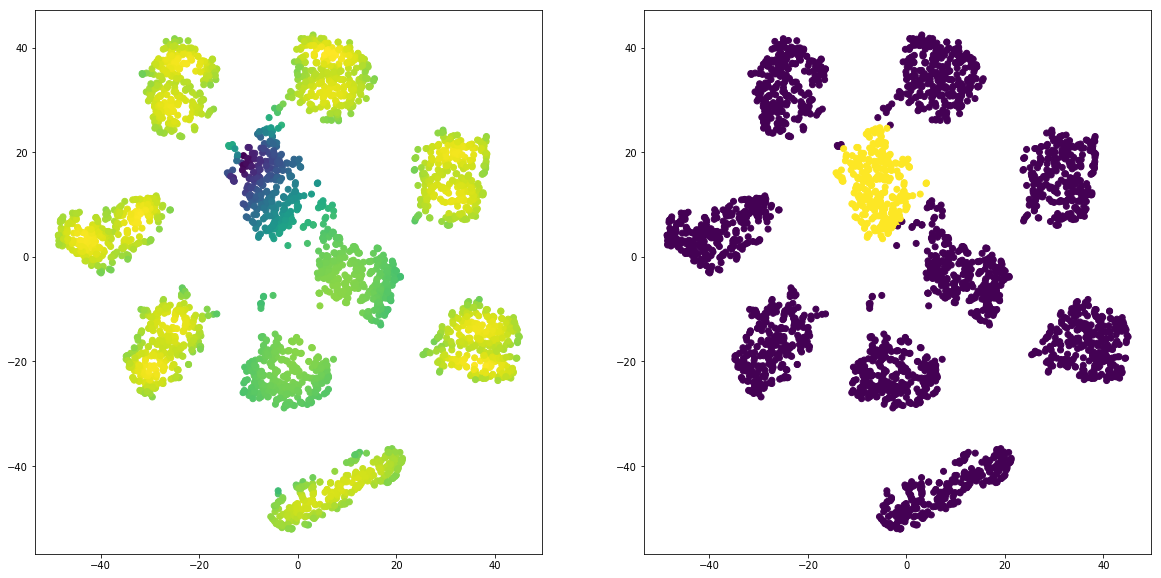

In [25]:
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0],tsne_all[:,1],c=probas) # certainty for each point
axes[1].scatter(tsne_all[:,0],tsne_all[:,1],c=probas<np.sort(probas)[300])  # 300 least certain points in yellow

In [26]:
# standardize network output to [0,1]
probas -= np.nanmin(probas)
probas /= np.nanmax(probas)

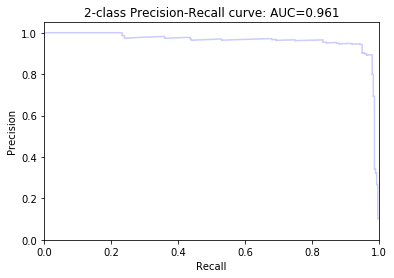

In [27]:
# Get precision, recall curve for test set using max margin
# max margin
y_scores = -probas
y_true=np.ones(len(tsne_all))
y_true[ind]=0
y_true
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall)

### Test on real activations

In [104]:
root_nodes = df_create(X_train, max_depth=3, min_subset=.1, 
                       n_trees=15, subsample_pct=.5, n_max_dim=0,
                       n_jobs=-1, verbose=10, fact_improvement=.1, 
                       funct=create_density_tree)

Number of points on which to train each tree: 5000
Minimum number of points in each leaf: 500


[Parallel(n_jobs=40)]: Done   2 out of  15 | elapsed:   11.7s remaining:  1.3min
[Parallel(n_jobs=40)]: Done   4 out of  15 | elapsed:   11.8s remaining:   32.6s
[Parallel(n_jobs=40)]: Done   6 out of  15 | elapsed:   12.0s remaining:   17.9s
[Parallel(n_jobs=40)]: Done   8 out of  15 | elapsed:   12.1s remaining:   10.6s
[Parallel(n_jobs=40)]: Done  10 out of  15 | elapsed:   12.2s remaining:    6.1s
[Parallel(n_jobs=40)]: Done  12 out of  15 | elapsed:   12.2s remaining:    3.1s


Number of created root nodes: 15
Mean number of clusters created per tree: 11


[Parallel(n_jobs=40)]: Done  15 out of  15 | elapsed:   12.4s finished


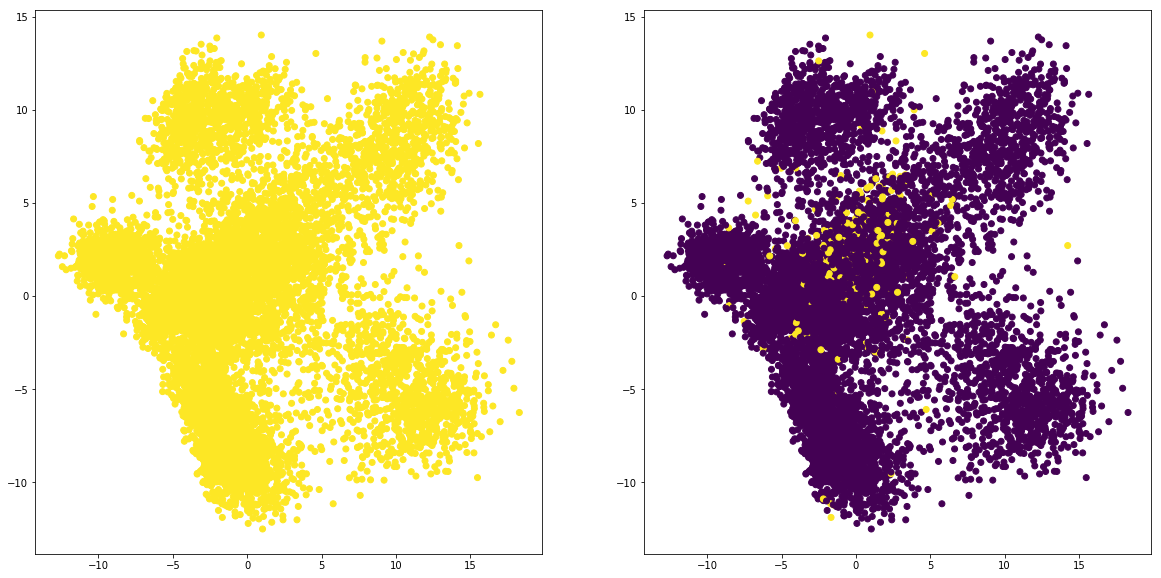

In [105]:
probas = df_traverse(X_test, root_nodes, 0, standardize=True)

#probas -= np.min(probas)
#probas /= np.max(probas)
probas = np.log(probas)

fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(X_test[:,0],X_test[:,1],c=probas)
axes[1].scatter(X_test[:,0],X_test[:,1],c=probas<np.sort(probas)[300])

# standardize network output to [0,1]
probas -= np.nanmin(probas)
probas /= np.nanmax(probas)

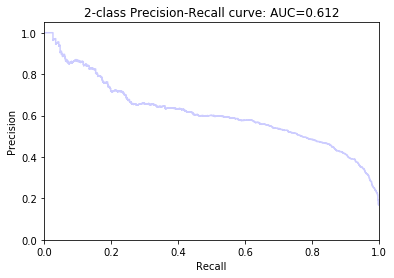

In [106]:
# Get precision, recall curve for test set using max margin
# max margin
y_scores = -probas
y_true=np.zeros(len(X_test))
y_true[y_test_all==label_to_remove]=1
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)

plt.figure()
plot_precision_recall(precision, recall)